# Multi-Class Image Classification Model for Food 101 Identification Using TensorFlow Take 4
### David Lowe
### July 14, 2022

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Belgium Traffic Sign dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset includes 101 food categories, totaling 101,000 images. The research team provided 250 manually reviewed test images and 750 training images for each food type. All images were rescaled to have a maximum side length of 512 pixels.

ANALYSIS: The VGG19 model's performance achieved an accuracy score of 76.07% after ten epochs using the training dataset. When we applied the model to the validation dataset, the model achieved an accuracy score of 67.78%.

CONCLUSION: In this iteration, the TensorFlow VGG19 CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Multi-Class classification with numerical features

Dataset Used: Food-101 – Mining Discriminative Components with Random Forests

Dataset Reference: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

One source of potential performance benchmarks: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

# Task 1 - Prepare Environment

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Jul 11 22:35:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    47W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00001)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 101
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'food-101/images/'
# VALID_DIR = ''
# TEST_DIR = ''
TRAIN_DATASET = 'food-101.tar.gz'
# VALID_DATASET = ''
# TEST_DATASET = ''
TRAIN_LABELS = 'food-101/meta/train.txt'
# VALID_LABELS = ''
TEST_LABELS = 'food-101/meta/test.txt'
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.8.2


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [10]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Clean up the old files and download directories before receiving new ones
!rm -rf food-101/

if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/tensorflow-food-101/food-101.tar.gz
!tar -xzf food-101.tar.gz
!du -h

60K	./.config/logs/2022.07.06
64K	./.config/logs
8.0K	./.config/configurations
96K	./.config
58M	./food-101/images/pizza
48M	./food-101/images/macaroni_and_cheese
51M	./food-101/images/chicken_quesadilla
56M	./food-101/images/seaweed_salad
53M	./food-101/images/beignets
52M	./food-101/images/huevos_rancheros
56M	./food-101/images/baby_back_ribs
49M	./food-101/images/hot_dog
47M	./food-101/images/dumplings
42M	./food-101/images/lobster_bisque
54M	./food-101/images/nachos
54M	./food-101/images/guacamole
47M	./food-101/images/tuna_tartare
47M	./food-101/images/bread_pudding
48M	./food-101/images/deviled_eggs
50M	./food-101/images/gnocchi
51M	./food-101/images/spaghetti_carbonara
49M	./food-101/images/hummus
49M	./food-101/images/carrot_cake
44M	./food-101/images/cheesecake
53M	./food-101/images/steak
48M	./food-101/images/scallops
52M	./food-101/images/falafel
52M	./food-101/images/grilled_cheese_sandwich
56M	./food-101/images/greek_salad
56M	./food-101/images/french_toast
54M	./food-101/

In [12]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)

['pizza', 'macaroni_and_cheese', 'chicken_quesadilla', 'seaweed_salad', 'beignets', 'huevos_rancheros', 'baby_back_ribs', 'hot_dog', 'dumplings', 'lobster_bisque', 'nachos', 'guacamole', 'tuna_tartare', 'bread_pudding', 'deviled_eggs', 'gnocchi', 'spaghetti_carbonara', 'hummus', 'carrot_cake', 'cheesecake', 'steak', 'scallops', 'falafel', 'grilled_cheese_sandwich', 'greek_salad', 'french_toast', 'mussels', 'baklava', 'bruschetta', 'hot_and_sour_soup', 'samosa', 'peking_duck', 'edamame', 'french_onion_soup', 'bibimbap', 'clam_chowder', 'cannoli', 'eggs_benedict', 'oysters', 'pork_chop', 'creme_brulee', 'red_velvet_cake', 'grilled_salmon', 'filet_mignon', 'pad_thai', 'french_fries', 'beef_carpaccio', 'croque_madame', 'panna_cotta', 'pulled_pork_sandwich', 'shrimp_and_grits', 'cup_cakes', 'waffles', 'frozen_yogurt', 'tacos', 'risotto', 'poutine', 'lobster_roll_sandwich', 'ravioli', 'churros', 'hamburger', 'tiramisu', 'garlic_bread', 'cheese_plate', 'chocolate_cake', 'donuts', 'gyoza', 'mi

In [13]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for pizza : 1000
Training samples for pizza : ['2155735.jpg', '1836888.jpg', '376625.jpg', '2639094.jpg', '1705773.jpg'] 

Number of training images for macaroni_and_cheese : 1000
Training samples for macaroni_and_cheese : ['3284998.jpg', '596154.jpg', '3114981.jpg', '1041383.jpg', '1938583.jpg'] 

Number of training images for chicken_quesadilla : 1000
Training samples for chicken_quesadilla : ['3343572.jpg', '850695.jpg', '140290.jpg', '3512949.jpg', '1497643.jpg'] 

Number of training images for seaweed_salad : 1000
Training samples for seaweed_salad : ['488339.jpg', '829671.jpg', '2417030.jpg', '803239.jpg', '1019344.jpg'] 

Number of training images for beignets : 1000
Training samples for beignets : ['297486.jpg', '283136.jpg', '1904654.jpg', '3256090.jpg', '3453845.jpg'] 

Number of training images for huevos_rancheros : 1000
Training samples for huevos_rancheros : ['3050063.jpg', '2131614.jpg', '507445.jpg', '3837886.jpg', '1379900.jpg'] 

Number of tr

In [14]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [15]:
df_train_images = pd.read_csv(TRAIN_LABELS, names=['image'])
df_train_images['image'] = df_train_images['image'] + '.jpg'
df_train_images['class'] = df_train_images['image'].apply(lambda x: x[0:x.find('/')])
print(df_train_images.head())

In [16]:
df_test_images = pd.read_csv(TEST_LABELS, names=['image'])
df_test_images['image'] = df_test_images['image'] + '.jpg'
df_test_images['class'] = df_test_images['image'].apply(lambda x: x[0:x.find('/')])
print(df_test_images.head())

In [17]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(dataframe=df_train_images,
                                                          directory='food-101/images/',
                                                          x_col='image',
                                                          y_col='class',
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_test_images,
                                                              directory='food-101/images/',
                                                              x_col='image',
                                                              y_col='class',
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

In [18]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [19]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [20]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [21]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [22]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
2368/2368 [==============================] - 1374s 574ms/step - loss: 2.9504 - accuracy: 0.3007 - val_loss: 2.0432 - val_accuracy: 0.4781
Epoch 2/10
2368/2368 [==============================] - 1320s 557ms/step - loss: 1.9484 - accuracy: 0.5065 - val_loss: 1.6447 - val_accuracy: 0.5648
Epoch 3/10
2368/2368 [==============================] - 1283s 542ms/step - loss: 1.6434 - accuracy: 0.5760 - val_loss: 1.4647 - val_accuracy: 0.6121
Epoch 4/10
2368/2368 [==============================] - 1265s 534ms/step - loss: 1.4545 - accuracy: 0.6221 - val_loss: 1.3519 - val_accuracy: 0.6347
Epoch 5/10
2368/2368 [==============================] - 1254s 529ms/step - loss: 1.3168 - accuracy: 0.6519 - val_loss: 1.2651 - val_accuracy: 0.6565
Epoch 6/10
2368/2368 [==============================] - 1254s 530ms/step - loss: 1.1989 - accuracy: 0.6821 - val_loss: 1.1735 - val_accuracy: 0.6828
Epoch 7/10
2368/2368 [==============================] - 1248s 527ms/step - loss: 1.1045 - accuracy: 0.7036

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 dense_1 (Dense)             (None, 101)               206949    
                                                                 
Total params: 290,447,237
Trainable params: 290,412,805
Non-trainable params: 34,432
_________________________________________________________________


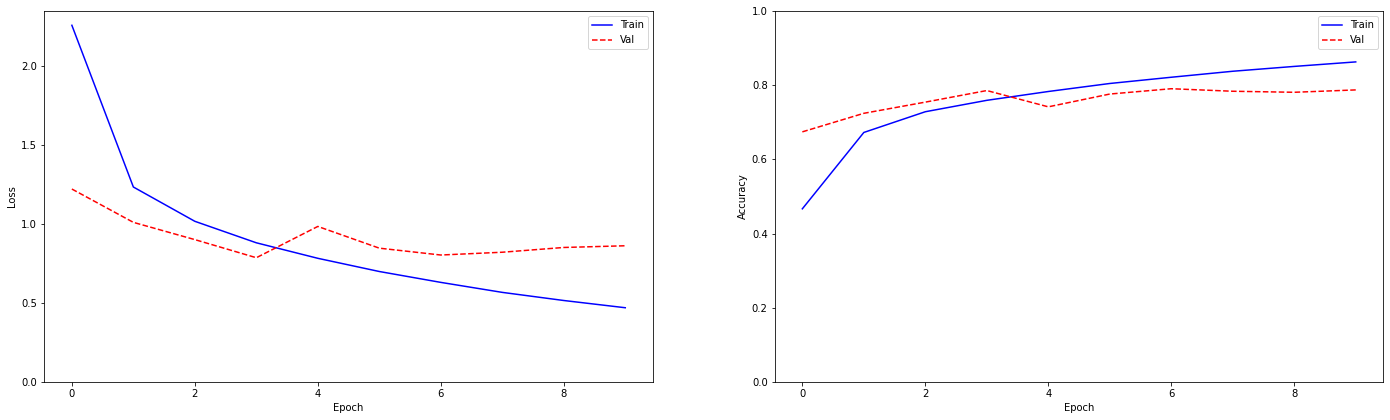

In [ ]:
plot_metrics(baseline_model_history)

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Not applicable for this iteration of modeling

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Not applicable for this iteration of modeling

In [ ]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 4:47:56.815786
